In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import japanize_matplotlib
import scipy.stats as ss
import statsmodels.api as sm
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, '../')  # 上位ディレクトリのパスを追加する
import pscore as p
import plotly.express as px

# データ準備

In [2]:
rct_df = pd.read_csv('../rct_df.csv')
rct_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [3]:
male_df = rct_df.query('segment != "Womens E-Mail"')
male_df['treatment'] = male_df.segment.apply(lambda x: 1 if x == 'Mens E-Mail' else 0)

male_df.head()

/var/folders/j0/dprt9y4n7hjcjnr0fw0wxf300000gn/T/ipykernel_13956/1484658408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df['treatment'] = male_df.segment.apply(lambda x: 1 if x == 'Mens E-Mail' else 0)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0


In [4]:
male_df = pd.concat([male_df,
                     pd.get_dummies(male_df.channel,
                                    drop_first=True,
                                    prefix_sep='_',
                                    prefix='channel')],
                    axis=1)

# treatmentとcontrolで平均の差を比較
rct_summary = male_df.groupby('treatment')[['conversion', 'spend']].agg(['mean','count'])
true_effect_value = rct_summary['spend']['mean'][1] - rct_summary['spend']['mean'][0]
true_effect_value

0.7698271558945364

# バイアスのあるデータを準備

In [5]:
# treatmentでは購買意欲の高い顧客を全てに入れ、controlでは購買意欲が高い人間を若干削除している
np.random.seed(1)
male_df['random_num'] = np.random.uniform(0,1,male_df.count()[0])
male_df['rate_c'] = 1.0
male_df['rate_t'] = 0.25
idxs = male_df.query('history > 300 & recency < 6').index
male_df.loc[idxs,'rate_c'] = 0.5
male_df.loc[idxs,'rate_t'] = 1
biased_data = pd.concat([male_df.query('treatment == 0 & random_num < rate_c'), male_df.query('treatment == 1 & random_num < rate_t')])
biased_data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,channel_Phone,channel_Web,random_num,rate_c,rate_t
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,0,1,0.417022,1.0,0.25
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,0,0,0.146756,1.0,0.25
15,3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0.0,0,0,1,0.092339,1.0,0.25
20,9,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0,0,1,0,0.419195,1.0,0.25
23,2,1) $0 - $100,29.99,0,1,Urban,1,Phone,No E-Mail,0,0,0.0,0,1,0,0.878117,1.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63978,10,2) $100 - $200,102.01,0,1,Urban,1,Phone,Mens E-Mail,0,0,0.0,1,1,0,0.018689,1.0,0.25
63985,9,1) $0 - $100,29.99,1,0,Urban,0,Phone,Mens E-Mail,1,0,0.0,1,1,0,0.203544,1.0,0.25
63988,6,1) $0 - $100,32.98,1,0,Surburban,0,Web,Mens E-Mail,0,0,0.0,1,0,1,0.060988,1.0,0.25
63992,1,5) $500 - $750,519.69,1,1,Urban,1,Phone,Mens E-Mail,0,0,0.0,1,1,0,0.656865,0.5,1.00


In [6]:
# 平均の比較
bias_summary = biased_data.groupby('treatment')[['conversion', 'spend']].agg(['mean','count'])
bias_effect_value = bias_summary['spend']['mean'][1] - bias_summary['spend']['mean'][0]
bias_effect_value

0.9887909244922427

# DRで推定

In [7]:
biased_data.columns

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel', 'segment', 'visit', 'conversion', 'spend',
       'treatment', 'channel_Phone', 'channel_Web', 'random_num', 'rate_c',
       'rate_t'],
      dtype='object')

In [8]:
# 傾向スコアの算出
bias_col = ['recency','history','channel_Phone','channel_Web']
x = biased_data[bias_col]
y = biased_data.treatment
sc_x = StandardScaler().fit_transform(x)
model = LogisticRegression()
model.fit(x,y)
biased_data['pscore'] = model.predict_proba(x)[:,1]
pscore = model.predict_proba(x)[:,1]

# treatment = 0の時の予測モデルのためのデータ準備
biased_data_x_0 = biased_data.query('treatment == 0')[bias_col]
y_0 = biased_data.query('treatment == 0').spend
# treatment=1の時の予測モデルのためのデータ準備
biased_data_x_1 = biased_data.query('treatment == 1')[bias_col]
y_1 = biased_data.query('treatment == 1').spend

# モデル作成
model0 = RandomForestRegressor(n_estimators=100,max_depth=3,random_state=0)
model0.fit(biased_data_x_0,y_0)
model1 = RandomForestRegressor(n_estimators=100,max_depth=3,random_state=0)
model1.fit(biased_data_x_1,y_1)
print(model0.score(biased_data_x_0,y_0), model1.score(biased_data_x_1,y_1))

0.040286702924268614 0.07166615063949788


In [9]:
N = len(biased_data)
D = biased_data.treatment
Y = biased_data.spend
Y_1 = model1.predict(biased_data[bias_col])
Y_0 = model0.predict(biased_data[bias_col])

DR_Y1 = (1 / N) * np.sum((D / pscore)*Y + (1 - (D / pscore))*Y_1)
DR_Y0 = (1 / N) * np.sum(((1 - D) / (1 - pscore))*Y + (1 - ((1 - D) / (1 - pscore)))*Y_0)

# ATEを算出
print(DR_Y1 - DR_Y0)
print(true_effect_value)

0.6302909869839052
0.7698271558945364


# ITEを算出し予測モデルを構築

In [46]:
# コントロールグループとトリートメントグループに分けて、モデルに学習させる
model0 = RandomForestRegressor(n_estimators=300,max_depth=3,random_state=0).fit(biased_data_x_0,y_0)
model1 = RandomForestRegressor(n_estimators=300,max_depth=3,random_state=0).fit(biased_data_x_1,y_1)

# y０とy１を推定(真の値)
y0 = model0.predict(biased_data_x_0) + (y_0 - model0.predict(biased_data_x_0))/(1 - biased_data.loc[biased_data_x_0.index,'pscore'])
y1 = model1.predict(biased_data_x_1) + (y_1 - model0.predict(biased_data_x_1))/(biased_data.loc[biased_data_x_1.index,'pscore'])

# y0の個体に介入があった場合の効果を予測。差分でiteを算出
biased_data_x_0['ite'] = model1.predict(biased_data_x_0) - y0
# y１のite
biased_data_x_1['ite'] = y1 - model0.predict(biased_data_x_1)
print('真の効果',true_effect_value,'平均因果効果:',np.mean(y1 - model0.predict(biased_data_x_1)) - np.mean(model1.predict(biased_data_x_0) - y0))

# データの結合
df_DR = pd.concat([biased_data_x_0, biased_data_x_1])

# iteを予測するモデルを作成し、未知データに対して効果を予測できるようにする。
theta = RandomForestRegressor(n_estimators=500 ,max_depth=20, max_features=10, random_state=0).fit(df_DR[bias_col], df_DR["ite"])
tau = theta.predict(biased_data[bias_col])
print('正解率',theta.score(df_DR[bias_col], df_DR["ite"]))

真の効果 0.7698271558945364 平均因果効果: -2.1428940008014297
正解率 0.8117335665378835


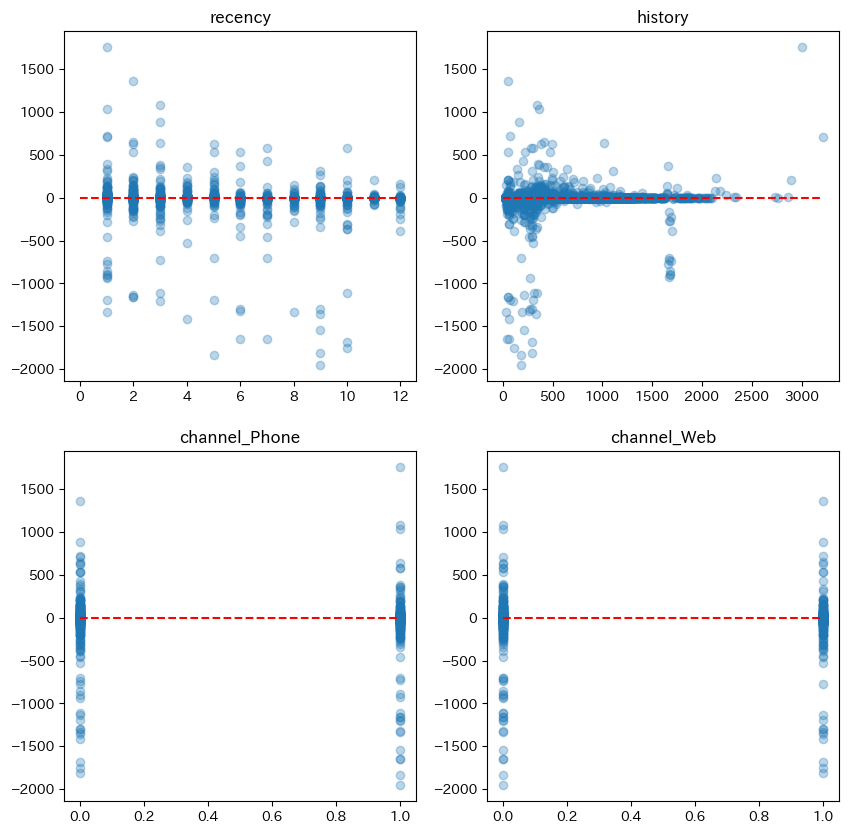

In [47]:
plt.figure(figsize=(10,10))
for num,i in enumerate(bias_col):
    plt.subplot(2,2,num+1)
    plt.title(f'{i}')
    plt.scatter(biased_data[f'{i}'], tau, alpha=0.3)
    plt.hlines(0, 0, max(biased_data[f'{i}']), linestyles='--', color="red")
plt.savefig('relation_ite_variable.png')
plt.show()

In [48]:
array1 = np.arange(0,20,1)
array2 = np.linspace(0,4000,20)

result = [(a, b) for a in array1 for b in array2]
tmp_df = pd.DataFrame(result)

tmp_df['tmp_cop1'] = 1
tmp_df['tmp_col2'] = 0
tmp_df.columns = bias_col

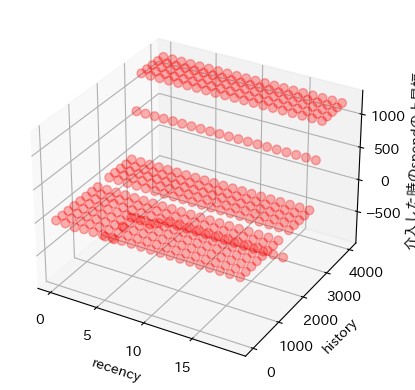

In [52]:
tmp_df.channel_Phone = 1
tmp_df.channel_Web = 0

#描画エリアの作成
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#numpyを使ってXYZの値を設定
x = tmp_df['recency']
y = tmp_df['history']
z = theta.predict(tmp_df)

ax.set_xlabel('recency')
ax.set_ylabel('history')
ax.set_zlabel('介入した時のspendの上昇幅')

#散布図の作成
ax.scatter(x,y,z,s=40,c="red", alpha=0.3)
# ax.plot_wireframe(x,y,z.reshape(-1,1),color="darkblue")
# ax.plot_surface(x,y,z.reshape(-1,1),cmap="winter")
    
#描画
plt.savefig('phone3d.png')
plt.show()

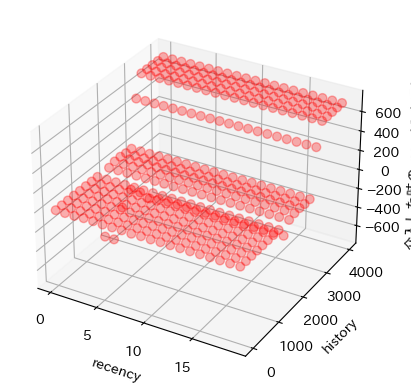

In [53]:
tmp_df.channel_Phone = 0
tmp_df.channel_Web = 1

#描画エリアの作成
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#numpyを使ってXYZの値を設定
x = tmp_df['recency']
y = tmp_df['history']
z = theta.predict(tmp_df)

ax.set_xlabel('recency')
ax.set_ylabel('history')
ax.set_zlabel('介入した時のspendの上昇幅')

#散布図の作成
ax.scatter(x,y,z,s=40,c="red", alpha=0.3)
# ax.plot_wireframe(x,y,z.reshape(-1,1),color="darkblue")
# ax.plot_surface(x,y,z.reshape(-1,1),cmap="winter")
    
#描画
plt.savefig('web3d.png')
plt.show()

In [51]:
theta.predict(tmp_df.query('history ==  0'))

array([ 0.0689376 ,  0.0689376 ,  0.06905156,  5.90531993,  4.74923493,
        0.06901779,  0.06837094,  0.06795206, -4.58705104,  0.06053853,
       -2.63693604, -0.41348373, -1.36036253, -1.36036253, -1.36036253,
       -1.36036253, -1.36036253, -1.36036253, -1.36036253, -1.36036253])

# 参考サイト
https://zenn.dev/s1ok69oo/articles/c058108acb83e7  
https://tech.ledge.co.jp/entry/dr  
https://zenn.dev/s1ok69oo/articles/1d35bc0cfaec49  
https://www.ism.ac.jp/editsec/toukei/pdf/62-1-103.pdf  
https://blog.minethatdata.com/  
